<a href="https://colab.research.google.com/github/NicoAN42/SKRPSI/blob/main/2022_Nadam_All_Lyr_Cbam_tt_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from tensorflow.keras.layers import Conv2D, Input, concatenate, Activation, InputLayer, Dense, Reshape, Flatten, Add, multiply, Permute, Lambda, Concatenate
from tensorflow.keras.layers import LeakyReLU,ReLU, MaxPooling2D, BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.activations import softmax,sigmoid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,SpatialDropout2D,GaussianDropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras import backend as K
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import StratifiedKFold
import os
import random
import shutil

In [3]:
#from tensorflow.keras.optimizers import SGD

In [4]:
CLASS = 3
#sourcepath isi semua data train, folder valid kosongin datanya sisai folder classnya
sourcePath = '/content/drive/MyDrive/Colab Notebooks/Dataset 2'
train_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 2/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 2/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 2/test'
attention_module = 'cbam_block'
#nico

In [5]:
classLabels =['covid','normal', 'pneumonia']

In [6]:
def attach_attention_module(net, attention_module):
  #if attention_module == 'se_block': # SE_block
    #net = se_block(net)
  if attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

In [7]:
def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature


In [8]:
def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

In [9]:
def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [10]:
input = Input(shape=(256,256,3))

In [11]:
#Layer 1
model = layers.Conv2D(32, (3,3), padding='same', name='conv_1', activation = 'relu')(input)
model = layers.BatchNormalization(name='norm_1')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides= 2)(model)
attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])


In [12]:
#Layer 2
model = layers.Conv2D(64, (3,3), padding='same', name='conv_2', activation = 'relu')(model)
model = layers.Dropout(0.1)(model)
model = layers.BatchNormalization(name='norm_2')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])


In [13]:
# Layer 3
model = layers.Conv2D(64, (3,3), padding='same', name='conv_3', activation = 'relu')(model)
model = layers.BatchNormalization(name='norm_3')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])



In [14]:
# Layer 4
model = layers.Conv2D(128, (3,3), padding='same', name='conv_4', activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_4')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])


In [15]:
# Layer 5
model = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')(model)
layer = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')
batch = layers.BatchNormalization(name='norm_5')
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_5')(model)
#model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

In [16]:
model = layers.Flatten()(model)
model = layers.Dense(128, activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
output = layers.Dense(3,Activation('softmax'))(model)
model = Model(input, output)

In [17]:
print(input)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [18]:
opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [19]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )

In [20]:
print(model.summary())
print(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 256, 256, 32  128         ['conv_1[0][0]']                 
                                )                                                             

In [21]:
X = []
Y = []
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        

In [22]:
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(sourcePath+'/'+source+'/'+label+'/', 
                               sourcePath+'/'+dest+'/'+label+'/', 
                               splitRate)
#First cut all images from validation to train (if any exists)
transferAllClassBetweenFolders('valid', 'train', 1.0)
#no valid
transferAllClassBetweenFolders('test', 'train', 1.0)

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!


In [23]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(sourcePath+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='micro')
    f1Score=f1_score(y_true, y_pred, average='micro') 
    recall = recall_score(y_true, y_pred, average='micro')
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    print("Recall : {}".format(recall))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)

    print("***----------------------------***")  
    return accuracy, precision, f1Score, recall

In [24]:
transferAllClassBetweenFolders('valid', 'train', 1.0)
transferAllClassBetweenFolders('test', 'train', 1.0)
X=np.asarray(X)
Y=np.asarray(Y)

print(X)
print(Y)

skf = StratifiedKFold(n_splits=5
                      , shuffle=True)
skf.get_n_splits(X, Y)
print(skf)
print(skf.get_n_splits(X,Y))
print(skf.split(X,Y))
foldNum=0
overAllAcc = 0
overAllPrec = 0
overAllf1 = 0
overAllRec = 0

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
['COVID(7).png' 'COVID(89).png' 'COVID(32).png' ...
 'person99_virus_183.jpeg' 'person97_virus_181.jpeg'
 'person97_virus_180.jpeg']
[0 0 0 ... 2 2 2]
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
5
<generator object _BaseKFold.split at 0x7f36301657d0>


trn_indx: 2263 test_indx: 566
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 1
2263
566
Found 2263 images belonging to 3 classes.
Found 566 images belonging to 3 classes.
Epoch 1/25
71/71 - 846s - loss: 1.0642 - accuracy: 0.8679 - 846s/epoch - 12s/step
Epoch 2/25
71/71 - 25s - loss: 0.2066 - accuracy: 0.9452 - 25s/epoch - 347ms/step
Epoch 3/25
71/71 - 25s - loss: 0.1037 - accuracy: 0.9651 - 25s/epoch - 345ms/step
Epoch 4/25
71/71 - 24s - loss: 0.0731 - accuracy: 0.9792 - 24s/epoch - 345ms/step
Epoch 5/25
71/71 - 25s - loss: 0.0957 - accuracy: 0.9770 - 25s/epoch - 346ms/step
Epoch 6/25
71/71 - 24s - loss: 0.0511 - accuracy: 0.9841 - 24s/epoch - 343ms/step
Epoch 7/25
71/71 - 24s - loss: 0.0512 - accuracy: 0.9810 - 24s/epoch - 342ms/step
Epoch 8/25
71/71 - 24s - loss: 0.0611 - accuracy: 0.9775 - 24s/epoch - 343ms/step
Epoch 9/25
71/71 - 24s - loss

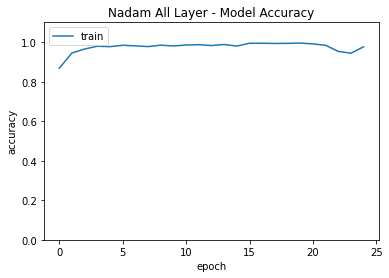

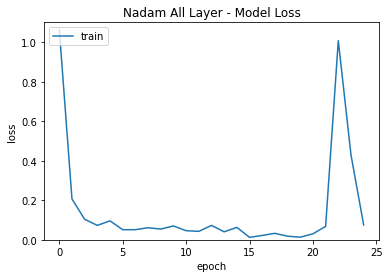

***Performance Data***
Accuracy  : 0.9734982332155477
Precision : 0.9734982332155477
f1Score : 0.9734982332155477
Recall : 0.9734982332155477
[[187   0   2]
 [  2 183   4]
 [  1   6 181]]
***----------------------------***
18/18 [==============================] - 6s 331ms/step - loss: 0.1359 - accuracy: 0.9735
***-----------------------------------------------***
Overall Accuracy:  0.9734982332155477
Overall Precision:  0.9734982332155477
Overall f1Score:  0.9734982332155477
Overall Recall:  0.9734982332155477
***------------------End of Line------------------***
trn_indx: 2263 test_indx: 566
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 2
2263
566
Found 2263 images belonging to 3 classes.
Found 566 images belonging to 3 classes.
Epoch 1/25
71/71 - 24s - loss: 0.0900 - accuracy: 0.9753 - 24s/epoch - 338ms/step
Epoch 2/25
71/71 - 24s - loss: 0.0440 - accuracy: 0.9854 - 24s/epoch - 339ms/step
Epoch 3/25
71/71 - 24s - loss: 0.0465 

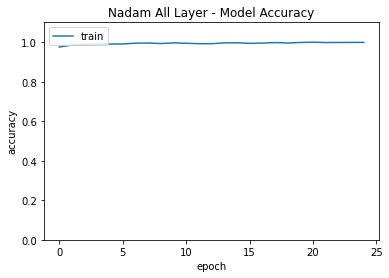

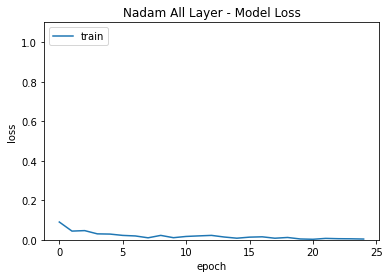

***Performance Data***
Accuracy  : 0.9858657243816255
Precision : 0.9858657243816255
f1Score : 0.9858657243816255
Recall : 0.9858657243816255
[[189   0   0]
 [  1 185   2]
 [  2   3 184]]
***----------------------------***
18/18 [==============================] - 6s 339ms/step - loss: 0.0408 - accuracy: 0.9859
***-----------------------------------------------***
Overall Accuracy:  0.9796819787985867
Overall Precision:  0.9796819787985867
Overall f1Score:  0.9796819787985867
Overall Recall:  0.9796819787985867
***------------------End of Line------------------***
trn_indx: 2263 test_indx: 566
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 3
2263
566
Found 2263 images belonging to 3 classes.
Found 566 images belonging to 3 classes.
Epoch 1/25
71/71 - 24s - loss: 0.0905 - accuracy: 0.9828 - 24s/epoch - 340ms/step
Epoch 2/25
71/71 - 24s - loss: 0.0513 - accuracy: 0.9854 - 24s/epoch - 340ms/step
Epoch 3/25
71/71 - 24s - loss: 0.0138 

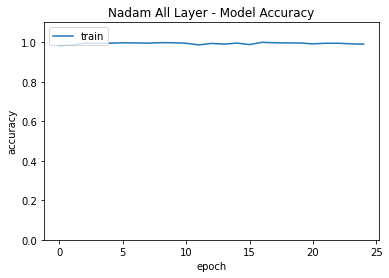

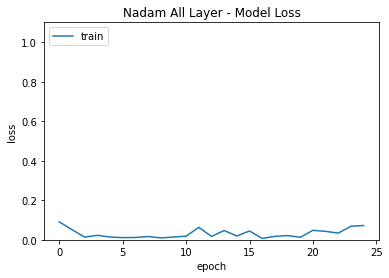

***Performance Data***
Accuracy  : 0.9028268551236749
Precision : 0.9028268551236749
f1Score : 0.9028268551236749
Recall : 0.9028268551236749
[[150  30   9]
 [  0 188   0]
 [  0  16 173]]
***----------------------------***
18/18 [==============================] - 6s 344ms/step - loss: 2.2127 - accuracy: 0.9028
***-----------------------------------------------***
Overall Accuracy:  0.9540636042402827
Overall Precision:  0.9540636042402827
Overall f1Score:  0.9540636042402827
Overall Recall:  0.9540636042402827
***------------------End of Line------------------***
trn_indx: 2263 test_indx: 566
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 4
2263
566
Found 2263 images belonging to 3 classes.
Found 566 images belonging to 3 classes.
Epoch 1/25
71/71 - 24s - loss: 0.0566 - accuracy: 0.9912 - 24s/epoch - 341ms/step
Epoch 2/25
71/71 - 24s - loss: 0.0206 - accuracy: 0.9938 - 24s/epoch - 343ms/step
Epoch 3/25
71/71 - 24s - loss: 0.0155 

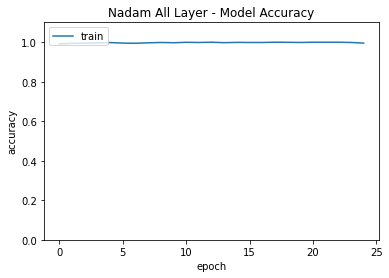

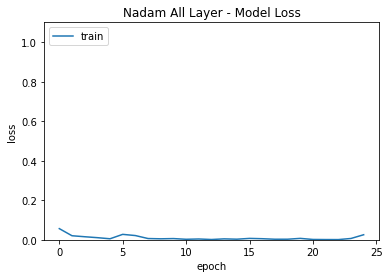

***Performance Data***
Accuracy  : 0.6607773851590106
Precision : 0.6607773851590106
f1Score : 0.6607773851590106
Recall : 0.6607773851590106
[[188   0   0]
 [118   9  62]
 [ 12   0 177]]
***----------------------------***
18/18 [==============================] - 6s 340ms/step - loss: 0.7168 - accuracy: 0.6608
***-----------------------------------------------***
Overall Accuracy:  0.8807420494699647
Overall Precision:  0.8807420494699647
Overall f1Score:  0.8807420494699647
Overall Recall:  0.8807420494699647
***------------------End of Line------------------***
trn_indx: 2264 test_indx: 565
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 5
2264
565
Found 2264 images belonging to 3 classes.
Found 565 images belonging to 3 classes.
Epoch 1/25
71/71 - 25s - loss: 0.0696 - accuracy: 0.9832 - 25s/epoch - 348ms/step
Epoch 2/25
71/71 - 24s - loss: 0.0286 - accuracy: 0.9938 - 24s/epoch - 339ms/step
Epoch 3/25
71/71 - 24s - loss: 0.0164 

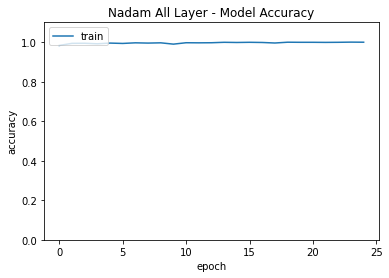

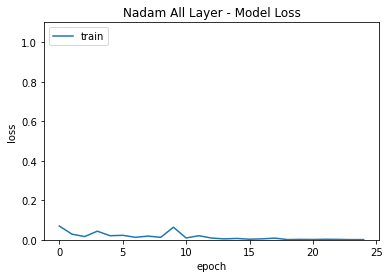

***Performance Data***
Accuracy  : 0.9964601769911504
Precision : 0.9964601769911504
f1Score : 0.9964601769911504
Recall : 0.9964601769911504
[[188   0   0]
 [  0 189   0]
 [  2   0 186]]
***----------------------------***
18/18 [==============================] - 6s 339ms/step - loss: 0.0291 - accuracy: 0.9965
***-----------------------------------------------***
Overall Accuracy:  0.9038856749742019
Overall Precision:  0.9038856749742019
Overall f1Score:  0.9038856749742019
Overall Recall:  0.9038856749742019
***------------------End of Line------------------***


In [25]:
for train_index, val_index in skf.split(X, Y):
    print("trn_indx: %s test_indx: %s" % (len(train_index), len(val_index)))
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('valid', 'train', 1.0)
    #no valid
    transferAllClassBetweenFolders('test', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    print(len(X_train))
    print(len(X_val))
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
          if(Y_val[eachIndex]==i):
              classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(sourcePath+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    #sourcePath+'/valid/'+classLabel+'/'+X_val[eachIndex])
        #without valid
                    sourcePath+'/test/'+classLabel+'/'+X_val[eachIndex])
        
    train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 32, shuffle=True)
    #without valid
    #valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 32, shuffle=True)
    test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 32, shuffle=False)

    history = model.fit(train_batches, 
                    #steps_per_epoch=sp_epoch, 
                    #without valid
                    #validation_data=valid_batches, 
                    #validation_steps=10, 
                    epochs=25, 
                    verbose=2)
    
    
    
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])
    plt.title('Nadam All Layer - Model Accuracy')
    plt.ylim(0,1.1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.legend(['train', 'valid'], loc='upper left')
    #without valid
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Nadam All Layer - Model Loss')
    plt.ylim(0,1.1)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'valid'], loc='upper left')
    #without valid
    plt.legend(['train'], loc='upper left')
    plt.show()
    test_batches.reset()
    Y_pred = model.predict(test_batches)
    classes = test_batches.classes[test_batches.index_array]
    y_pred = np.argmax(Y_pred, axis=-1)
    #print("***Performance on Test Data***")  
    #print(sum(y_pred==classes)/10000)
    confusion_matrix(test_batches.classes[test_batches.index_array],y_pred)
    #predictions = model.predict(test_batches, verbose=1)
    #yPredictions = np.argmax(predictions, axis=1)
    #print(yPredictions)
    #true_classes = test_batches.classes
    # evaluate validation performance
    print("***Performance Data***")    
    #valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)
    valAcc, valPrec, valFScore, valRec = my_metrics(classes, y_pred)
    overAllAcc = overAllAcc+valAcc
    overAllPrec = overAllPrec+valPrec
    overAllf1 = overAllf1+valFScore
    overAllRec = overAllRec+valRec
    
    model.evaluate(test_batches)
    print("***-----------------------------------------------***")  
    print("Overall Accuracy: ",  overAllAcc/foldNum)
    print("Overall Precision: ",  overAllPrec/foldNum)
    print("Overall f1Score: ",  overAllf1/foldNum)
    print("Overall Recall: ",  overAllRec/foldNum)

    print("***------------------End of Line------------------***")